Add: 
    - 6 Months around brexit for final Frame. Full for user party affiliation.
    - Only Lemmatized posts : Brexit, referendum, leave, remain, vote
    - Higher boundary to assign score. +- 5
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import load_data
from constants import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key text.latex.preview in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [3]:
dev = True

In [4]:
YEARS = [2016]
reddit = {}

In [5]:
for year in YEARS:
    reddit[year] = load_data(DATA_PATH, year=year, tokenize=False, comp="parquet", dev=False)

Loading data of 2016...


In [6]:
if dev:
    for year in YEARS:
        reddit[year] = reddit[year].sample(frac=0.15)

In [7]:
users = {}

for year in YEARS:
    print(year)
    for index, row in reddit[year].iterrows():
        if not row['subreddit'] in DEM_SUBREDDITS and not row['subreddit'] in REP_SUBREDDITS:
            continue
        else:
            try:
                users[row['author']].append(row['subreddit'])
            except KeyError:
                users[row['author']] = [row['subreddit']]


2016


In [ ]:
users_n_posts_df = pd.DataFrame([[user, len(users[user])] for user in users.keys()],
                                columns = ['user', 'n_posts'])
users_n_posts_df.to_csv('users_n_posts.csv')

In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from datetimerange import DateTimeRange

st = LancasterStemmer()

BREXIT = 'brexit'
BREX_LEMMAS= set([st.stem(word) for word in ['vote', 'leave', 'remain', 'referendum', 'cameron', 'uk', 'british']])
BREXIT_DATE = pd.to_datetime('2016-06-23')
START_RANGE = BREXIT_DATE - pd.Timedelta(90, unit='d')
END_RANGE = BREXIT_DATE + pd.Timedelta(90, unit='d')



def includes_lemma(post):
    tokenized_post = set([st.stem(token.lower()) for token in word_tokenize(post)])
    if BREXIT in tokenized_post:            
        return True
    elif np.sum([lemm in BREX_LEMMAS for lemm in tokenized_post]) >= 2:
        return True
    return False

def is_six_months_around_brexit(date):
    time_range = DateTimeRange(START_RANGE, END_RANGE)
    timestamp = pd.to_datetime(date)
    if timestamp in time_range:
        return True
    else:
        return False

In [9]:
def rep_or_dem_score(subreddits_list):
    score = 0
    for subreddit in subreddits_list:
        if subreddit in DEM_SUBREDDITS:
            score += 1
        elif subreddit in REP_SUBREDDITS:
            score -= 1
    return score
def rep_or_dem(score):
    if score >=1 : 
        return 'D'
    elif score <= -1:
        return 'R'
    return 'N'


In [10]:
user_affiliation = {}
users_affiliation_data = []
for key in users.keys():
    aff = rep_or_dem_score(users[key])
    if abs(aff) > 5:
        users_affiliation_data.append([key, aff])
        user_affiliation[key] = rep_or_dem(aff)

users_affiliation_df = pd.DataFrame(users_affiliation_data, columns=['user', 'score'])

In [11]:
print(users_affiliation_df)

                 user  score
0          Dol-Amroth    -47
1       thedesertlynx     -6
2     House_of_Jimena    -35
3       Pathos_Mathos    -28
4        AesirAnatman      7
...               ...    ...
6941   MaduinBranford     -6
6942      Auctoritate     -7
6943   pharmacyman848      6
6944       racionador     -7
6945          NonyaDB     -6

[6946 rows x 2 columns]


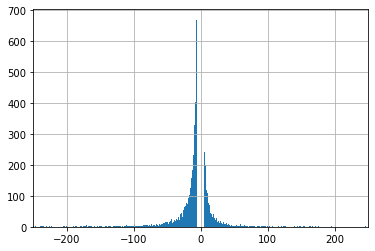

In [12]:
users_affiliation_df['score'].hist(bins=np.linspace(-250, 250, 500))
#plt.semilogx()
plt.xlim(-250,250)
plt.show()

In [13]:
users_affiliation_df.to_csv('BREXIT_user_affiliation.csv')

In [14]:
data = []
relevant_users = set(user_affiliation.keys())
for year in YEARS:
    print('YEAR -> ', year)
    reddit[year] = reddit[year][reddit[year]['subreddit']== 'politics'].compute()
    if dev:
        reddit[year] = reddit[year].iloc[np.random.randint(0, 
                                                           len(reddit[year]),
                                                           size = int(0.15*len(reddit[year])))]
    author_ = reddit[year].author.values
    created_ = reddit[year].created_utc.values
    body_ =  reddit[year].body.values
    for author, created, body in zip(author_, created_, body_):
        if author in relevant_users:
            if is_six_months_around_brexit(created):
                if includes_lemma(body):
                    affiliation = user_affiliation[author] 
                    new_line = [author, body, created, affiliation]
                    data.append(new_line)
                
output_dataframe = pd.DataFrame(data, columns= ['author', 'post', 'time', 'politics'])


YEAR ->  2016


In [15]:
output_dataframe.to_csv('BREXIT_reduced_data.csv')

In [16]:
output_dataframe

,author,post,time,politics
0,notmathrock,unfortunely that ship sailed long ago with reg...,2016-08-14,D
1,Elided_Ego,the infamous period of hyperinflation in the w...,2016-07-22,R
2,Chaos_Motor,can we fucking stop calling every dissenting v...,2016-07-03,R
3,GAforTrump,there is nothing more isolating than having ot...,2016-04-27,R
4,lurgi,i vote we change it to god save the queen . se...,2016-09-09,R
5,CHNLLOS_BIG_BOY,"before brexit , id agree . im not convinced ab...",2016-09-06,R
6,TheSourTruth,but the turnout for the brexit referendum was ...,2016-09-17,R
7,CountPanda,i take it youre not a liberal then . the worst...,2016-09-17,D
8,TheQuestion78,im honestly not sure that trump would be worse...,2016-06-28,R
9,MartyInDFW,hillary isnt center left . at best shes center...,2016-03-27,R
